In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
gpus = tf.config.experimental.list_physical_devices("GPU")

# Localization 1

## task: predict the location of white block

In [18]:
# transfer learning using vgg16
vgg = tf.keras.applications.VGG19(
    input_shape=[100, 100, 3], 
    include_top=False,
    weights="imagenet"
)

In [19]:
def window_pic_generator(batch_num = 50, batch_size = 64):
    while True:
        for _ in range(batch_num):
            X = np.zeros((batch_size, 100, 100, 3))
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size):
                x_0, y_0 = np.random.randint(90), np.random.randint(90)
                x_1, y_1 = np.random.randint(x_0, 90), np.random.randint(y_0, 90)
                X[i, x_0:x_1, y_0:y_1,:] = 1
                Y[i,:] = [x_0/100, y_0/100, (x_1-x_0)/100, (y_1-y_0)/100]
        yield X, Y

In [20]:
with tf.device('/GPU:0'):
    x = Flatten()(vgg.output)
    x = Dense(4, activation="sigmoid")(x)
    model = Model(vgg.input, x)
    model.compile(loss = "binary_crossentropy", 
    optimizer = Adam(learning_rate = 1e-3))

    model.fit(
        window_pic_generator(), 
        steps_per_epoch = 50,
        epochs = 8
    )

Epoch 1/8
50/50 [==============================] - 12s 179ms/step - loss: 0.7387
Epoch 2/8
50/50 [==============================] - 9s 178ms/step - loss: 0.5047
Epoch 3/8
50/50 [==============================] - 9s 175ms/step - loss: 0.4922
Epoch 4/8
50/50 [==============================] - 9s 178ms/step - loss: 0.4952
Epoch 5/8
50/50 [==============================] - 9s 177ms/step - loss: 0.4918
Epoch 6/8
50/50 [==============================] - 9s 178ms/step - loss: 0.4920
Epoch 7/8
50/50 [==============================] - 9s 181ms/step - loss: 0.4924
Epoch 8/8
50/50 [==============================] - 9s 175ms/step - loss: 0.4912


In [21]:
def make_prediction(model):
    x = np.zeros((100, 100, 3))
    x_0, y_0 = np.random.randint(0, 90), np.random.randint(0, 90)
    x_1, y_1 = np.random.randint(x_0, 100), np.random.randint(y_0, 100)
    x[x_0:x_1, y_0:y_1, :] = 1
    
    X = np.expand_dims(x, 0)
    pred = model.predict(X)[0]

    _, ax = plt.subplots(1)
    ax.imshow(x)
    rect = Rectangle(
        (pred[1]*100, pred[0]*100),
        pred[3]*100, pred[2]*100, linewidth = 1, edgecolor = "r", facecolor = "None"
    )
    ax.add_patch(rect)
    plt.show()

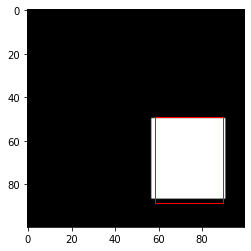

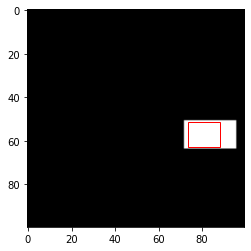

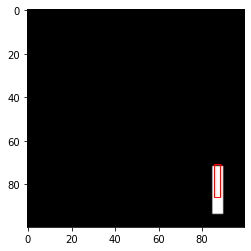

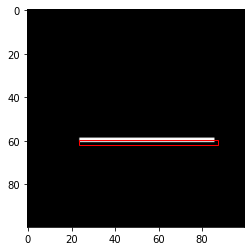

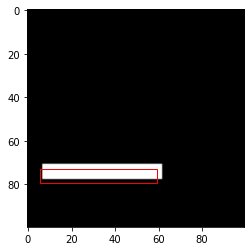

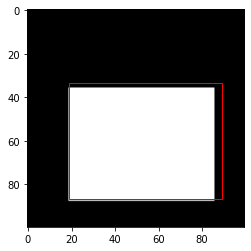

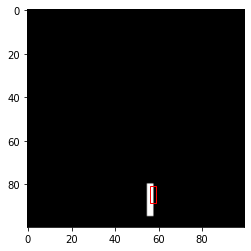

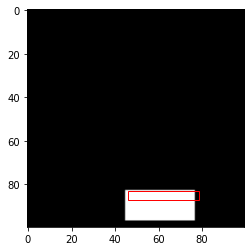

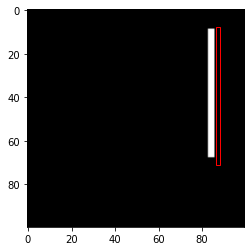

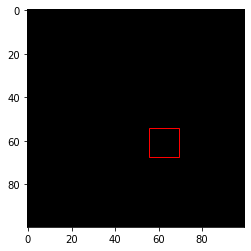

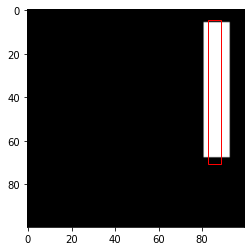

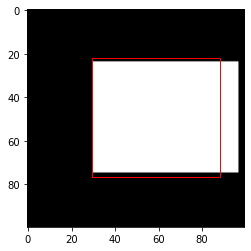

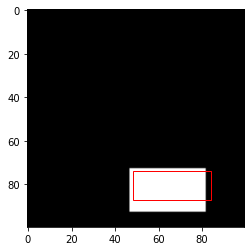

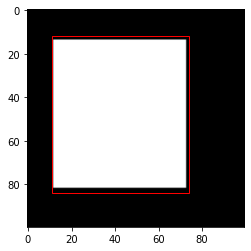

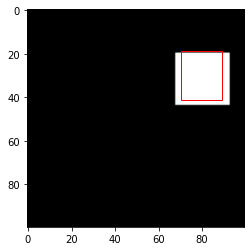

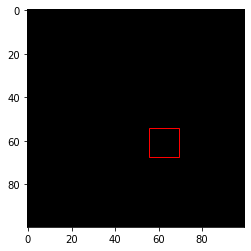

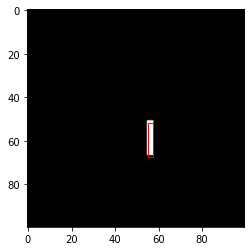

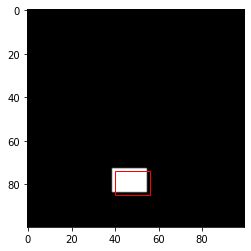

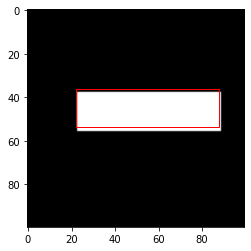

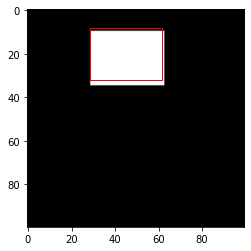

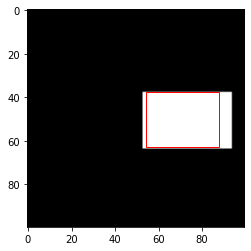

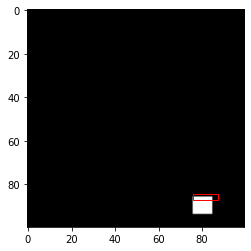

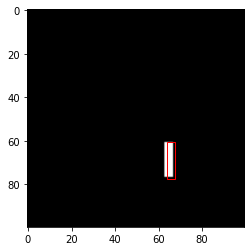

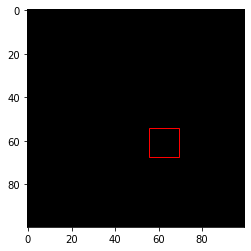

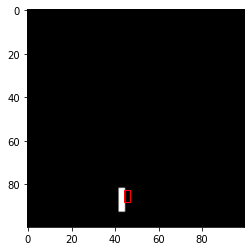

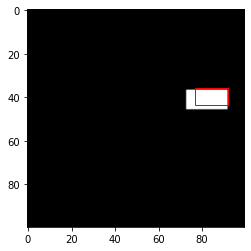

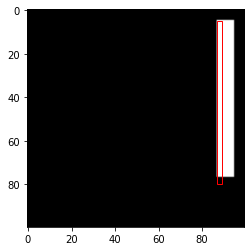

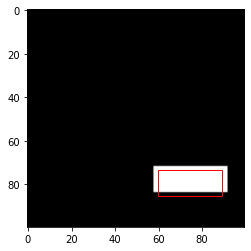

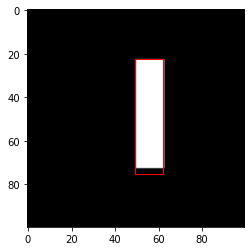

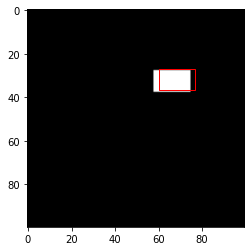

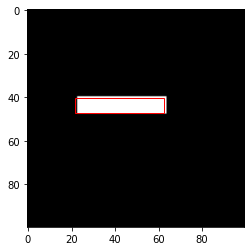

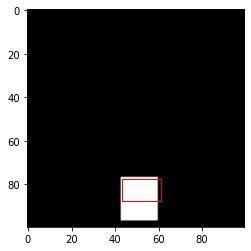

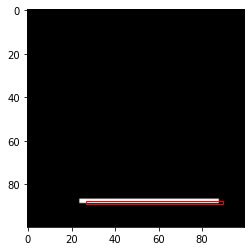

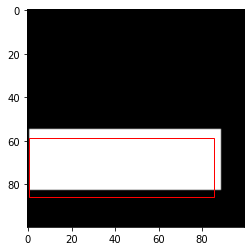

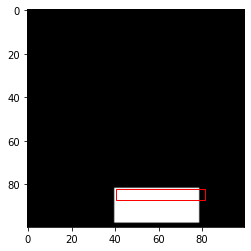

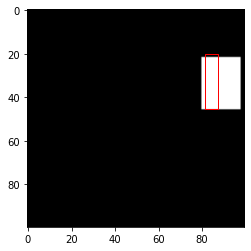

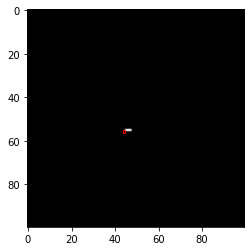

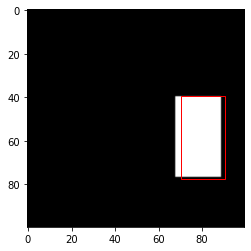

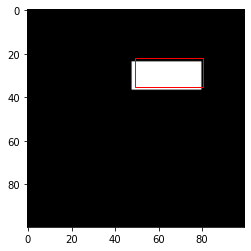

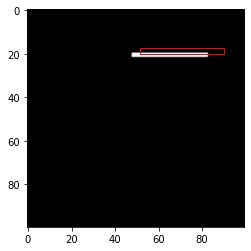

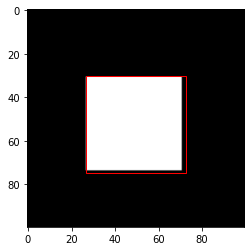

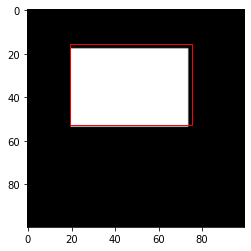

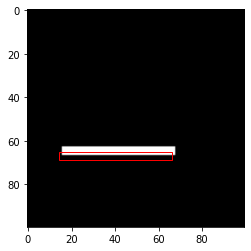

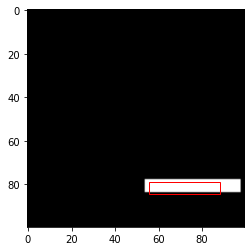

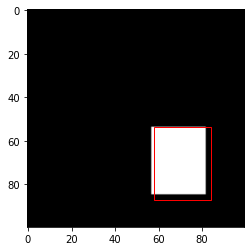

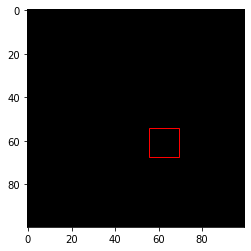

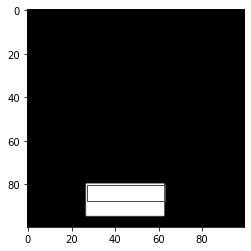

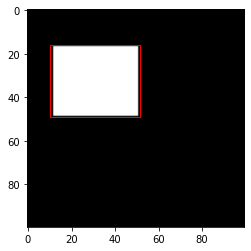

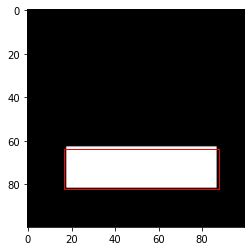

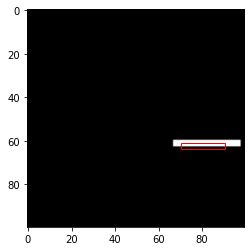

In [22]:
for _ in range(50):
    make_prediction(model)

# Localization 2
## task: predict the location of charmander in the figure

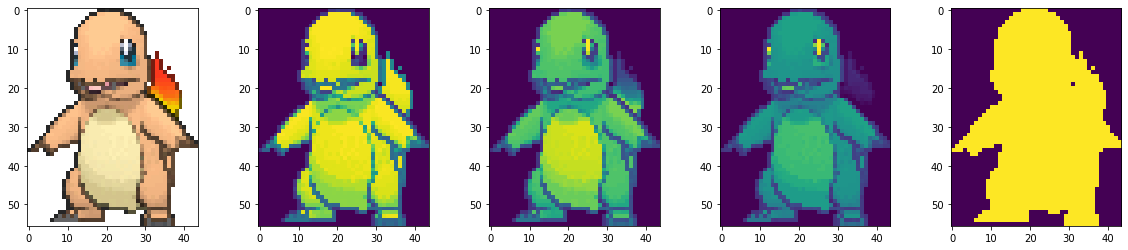

In [5]:
ch = imread('../data/charmander-tight.png')
fig, ax = plt.subplots(1, 5, figsize = (20, 4))
ax[0].imshow(ch)
ax[1].imshow(ch[:,:,0])
ax[2].imshow(ch[:,:,1])
ax[3].imshow(ch[:,:,2])
ax[4].imshow(ch[:,:,3])
plt.show()

In [6]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def charmander_generator(batch_num = 50, batch_size = 64):
    """
    generate charmander on black background
    """
    while True:
        for _ in range(batch_num):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size):
                # location of the charmander
                x_0, y_0 = np.random.randint(POKE_DIM - CH_H), np.random.randint(POKE_DIM - CH_W)
                x_1, y_1 = x_0 + CH_H, y_0 + CH_W
                X[i, x_0:x_1, y_0:y_1,:] = ch[:,:,:3]
                Y[i,:] = [x_0/POKE_DIM, y_0/POKE_DIM, (x_1-x_0)/POKE_DIM, (y_1-y_0)/POKE_DIM]
        yield X/255, Y

In [92]:
def make_model():
    vgg = tf.keras.applications.VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top = False, weights = "imagenet")
    x = Flatten()(vgg.output)
    x = Dense(4, activation="sigmoid")(x)
    model = Model(vgg.input, x)
    model.compile(loss = "binary_crossentropy", optimizer=Adam(learning_rate = 1e-3))
    return model

def make_charmander_prediction(model, color = 0):
    """
    generate charmander on black background
    """
    x = np.multiply(color, np.ones((POKE_DIM, POKE_DIM, 3)))
    # location of the charmander
    x_0, y_0 = np.random.randint(POKE_DIM - CH_H), np.random.randint(POKE_DIM - CH_W)
    x_1, y_1 = x_0 + CH_H, y_0 + CH_W
    x[x_0:x_1,y_0:y_1,:] = ch[:,:,:3]
    print("true location:", x_0, y_0, x_1, y_1)

    X = np.expand_dims(x, 0) / 255
    p = model.predict(X)[0]

    # calculate prediction
    y = np.zeros(4)
    y[0] = x_0/POKE_DIM
    y[1] = y_0/POKE_DIM
    y[2] = (x_1 - x_0)/POKE_DIM
    y[3] = (y_1 - y_0)/POKE_DIM

    # Draw the box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred:", row0, col0, row1, col1)
    # cross entropy loss
    print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))

    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [49]:
with tf.device('/GPU:0'):
    model = make_model()
    model.fit(
        charmander_generator(),
        steps_per_epoch=50,
        epochs=5
    )

Epoch 1/5
50/50 [==============================] - 25s 493ms/step - loss: 0.6455
Epoch 2/5
50/50 [==============================] - 25s 495ms/step - loss: 0.5552
Epoch 3/5
50/50 [==============================] - 25s 496ms/step - loss: 0.5545
Epoch 4/5
50/50 [==============================] - 25s 503ms/step - loss: 0.5534
Epoch 5/5
50/50 [==============================] - 25s 504ms/step - loss: 0.5549


true location: 37 98 93 142
pred: 36 98 91 142
loss: 0.5729359882324935


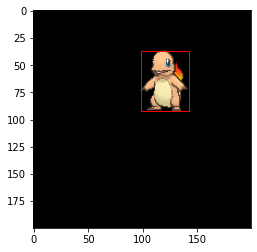

true location: 58 68 114 112
pred: 59 67 114 110
loss: 0.5907919353991747


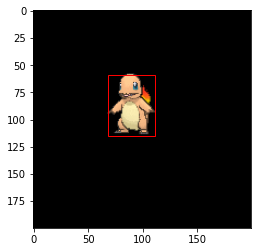

true location: 80 26 136 70
pred: 78 26 134 70
loss: 0.5448574413359166


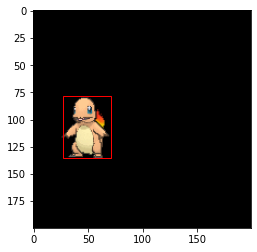

In [94]:
for _ in range(3):
    make_charmander_prediction(model)

true location: 137 17 193 61
pred: 121 16 177 60
loss: 0.5118288797419518


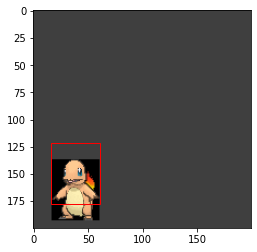

true location: 115 151 171 195
pred: 96 138 155 184
loss: 0.5963840939849615


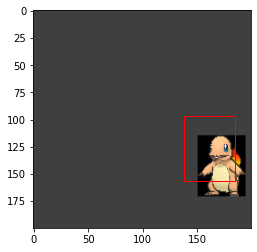

true location: 17 127 73 171
pred: 16 116 73 163
loss: 0.5184866996109485


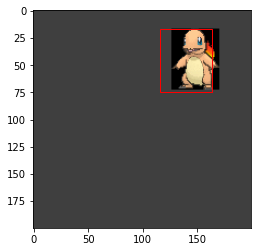

true location: 32 155 88 199
pred: 28 117 85 166
loss: 0.5435076202452183


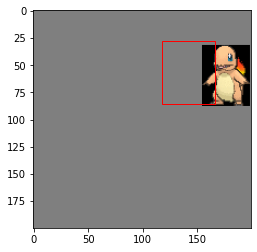

true location: 32 82 88 126
pred: 27 62 80 114
loss: 0.5661002527922392


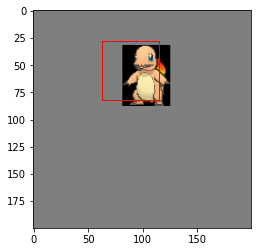

true location: 89 123 145 167
pred: 62 85 117 135
loss: 0.645962055362761


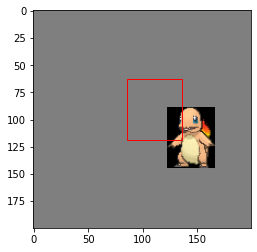

true location: 103 118 159 162
pred: 47 51 102 109
loss: 0.7334718926995992


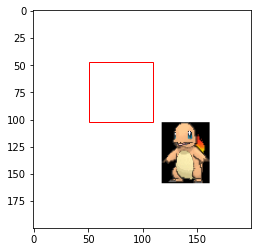

true location: 53 82 109 126
pred: 34 36 86 96
loss: 0.6397311830334366


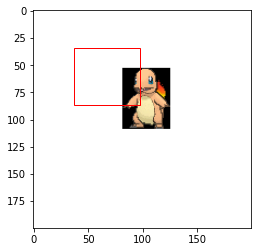

true location: 38 105 94 149
pred: 24 42 76 102
loss: 0.6423281217738986


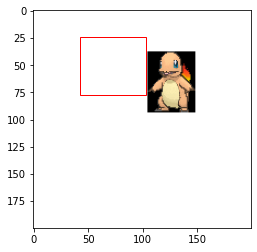

In [97]:
# the existing model fails predicting other background
for _ in range(3):
    # what if change the background to other colors
    make_charmander_prediction(model, 63)

for _ in range(3):
    # what if change the background to other colors
    make_charmander_prediction(model, 127)

for _ in range(3):
    # what if change the background to other colors
    make_charmander_prediction(model, 255)

# Localization 3
## task: different sizes of charmander

In [7]:
def charmander_generator_resize(batch_num = 50, batch_size = 64):
    """
    generate charmander on black background
    """
    while True:
        for _ in range(batch_num):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size):
                # resize scale [0, 2]
                # scale = 2 * np.random.random()
                scale = 0.5 + np.random.random()
                scaled_h, scaled_w = int(CH_H * scale), int(CH_W * scale)
                obj = resize(ch, (scaled_h, scaled_w), preserve_range=True).astype(np.uint8)

                # location of the charmander
                x_0, y_0 = np.random.randint(POKE_DIM - scaled_h), np.random.randint(POKE_DIM - scaled_w)
                x_1, y_1 = x_0 + scaled_h, y_0 + scaled_w
                X[i, x_0:x_1, y_0:y_1,:] = obj[:,:,:3]
                Y[i,:] = [x_0/POKE_DIM, y_0/POKE_DIM, (x_1-x_0)/POKE_DIM, (y_1-y_0)/POKE_DIM]
                
        yield X/255, Y

In [8]:
def make_model_resize():
    vgg = tf.keras.applications.VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],include_top = False, weights = "imagenet")
    x = Flatten()(vgg.output)
    x = Dense(4, activation="sigmoid")(x)
    model = Model(vgg.input, x)
    model.compile(loss = "binary_crossentropy", optimizer=Adam(learning_rate = 5e-4))
    return model

def make_charmander_prediction_resize(model, color = 0):
    """
    generate charmander on black background
    """
    # scale = 2 * np.random.random()
    scale = 0.5 + np.random.random()
    scaled_h, scaled_w = int(CH_H * scale), int(CH_W * scale)
    obj = resize(ch, (scaled_h, scaled_w), preserve_range=True).astype(np.uint8)
    x = np.multiply(color, np.ones((POKE_DIM, POKE_DIM, 3)))

    # location of the charmander
    x_0, y_0 = np.random.randint(POKE_DIM - scaled_h), np.random.randint(POKE_DIM - scaled_w)
    x_1, y_1 = x_0 + scaled_h, y_0 + scaled_w
    x[x_0:x_1,y_0:y_1,:] = obj[:,:,:3]
    print("true location:", x_0, y_0, x_1, y_1)

    X = np.expand_dims(x, 0) / 255
    p = model.predict(X)[0]

    # calculate prediction
    y = np.zeros(4)
    y[0] = x_0/POKE_DIM
    y[1] = y_0/POKE_DIM
    y[2] = (x_1 - x_0)/POKE_DIM
    y[3] = (y_1 - y_0)/POKE_DIM

    # Draw the box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred:", row0, col0, row1, col1)
    
    # cross entropy loss
    print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))

    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,
        linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [10]:
with tf.device('/GPU:0'):
    model_resize = make_model_resize()
    model_resize.fit(
        charmander_generator_resize(),
        steps_per_epoch=50,
        epochs=5
    )

Epoch 1/5
50/50 [==============================] - 208s 4s/step - loss: 0.5912
Epoch 2/5
50/50 [==============================] - 206s 4s/step - loss: 0.5465
Epoch 3/5
50/50 [==============================] - 205s 4s/step - loss: 0.5449
Epoch 4/5
50/50 [==============================] - 214s 4s/step - loss: 0.5439
Epoch 5/5
50/50 [==============================] - 204s 4s/step - loss: 0.5446


true location: 4 96 63 142
pred: 4 96 59 139
loss: 0.4844528582319617


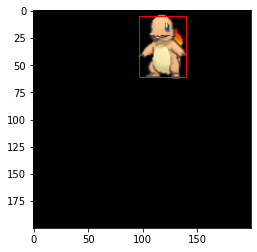

true location: 15 128 59 163
pred: 16 127 58 160
loss: 0.47776552592404187


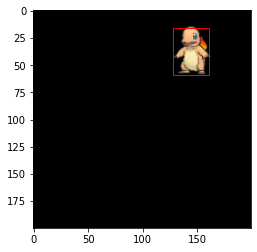

true location: 37 25 110 82
pred: 37 25 107 79
loss: 0.5275973068736493


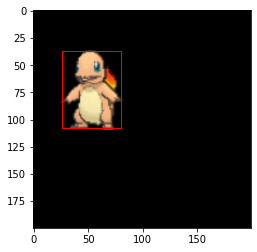

true location: 115 114 165 153
pred: 115 114 166 154
loss: 0.605321596711874


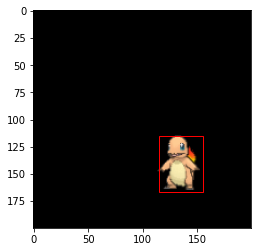

true location: 97 10 142 45
pred: 95 9 137 43
loss: 0.4722049415111541


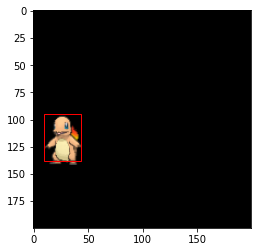

true location: 17 102 98 166
pred: 17 105 94 165
loss: 0.5719531251676381


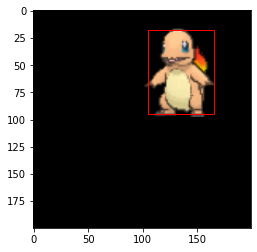

true location: 116 70 151 98
pred: 114 71 149 98
loss: 0.5491713845543563


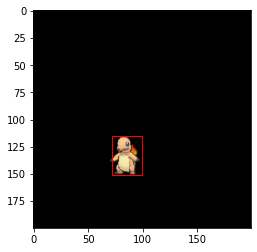

true location: 75 108 158 173
pred: 75 111 155 173
loss: 0.665502817556262


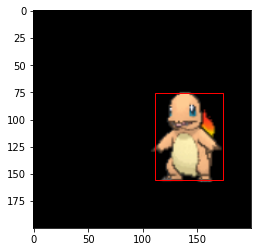

true location: 44 100 109 151
pred: 44 100 105 147
loss: 0.6049291626363993


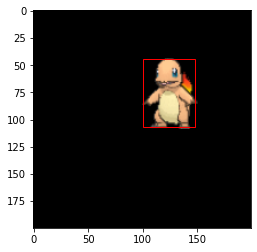

true location: 120 68 196 128
pred: 121 71 197 129
loss: 0.6475090047717094


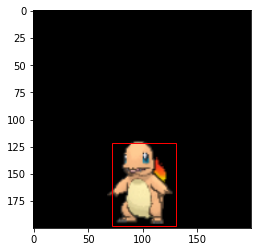

In [11]:
for _ in range(10):
    make_charmander_prediction_resize(model_resize)

# Localization 4
## task: flip the charmander

In [13]:
def charmander_generator_resize_flip(batch_num = 50, batch_size = 64):
    """
    generate charmander on black background
    """
    while True:
        for _ in range(batch_num):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 4))

            for i in range(batch_size):
                # resize scale [0, 2]
                # scale = 2 * np.random.random()
                scale = 0.5 + np.random.random()
                scaled_h, scaled_w = int(CH_H * scale), int(CH_W * scale)
                obj = resize(ch, (scaled_h, scaled_w), preserve_range=True).astype(np.uint8)

                # maybe flip
                if np.random.random() < 0.5:
                    obj = np.fliplr(obj)

                # location of the charmander
                x_0, y_0 = np.random.randint(POKE_DIM - scaled_h), np.random.randint(POKE_DIM - scaled_w)
                x_1, y_1 = x_0 + scaled_h, y_0 + scaled_w
                X[i, x_0:x_1, y_0:y_1,:] = obj[:,:,:3]
                Y[i,:] = [x_0/POKE_DIM, y_0/POKE_DIM, (x_1-x_0)/POKE_DIM, (y_1-y_0)/POKE_DIM]
                
        yield X/255, Y

In [14]:
def make_model_resize_flip():
    vgg = tf.keras.applications.VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],include_top = False, weights = "imagenet")
    x = Flatten()(vgg.output)
    x = Dense(4, activation="sigmoid")(x)
    model = Model(vgg.input, x)
    model.compile(loss = "binary_crossentropy", optimizer=Adam(learning_rate = 5e-4))
    return model

def make_charmander_prediction_resize_flip(model, color = 0):
    """
    generate charmander on black background
    """
    # scale = 2 * np.random.random()
    scale = 0.5 + np.random.random()
    scaled_h, scaled_w = int(CH_H * scale), int(CH_W * scale)
    obj = resize(ch, (scaled_h, scaled_w), preserve_range=True).astype(np.uint8)
    x = np.multiply(color, np.ones((POKE_DIM, POKE_DIM, 3)))

    # maybe flip
    if np.random.random() < 0.5:
        obj = np.fliplr(obj)

    # location of the charmander
    x_0, y_0 = np.random.randint(POKE_DIM - scaled_h), np.random.randint(POKE_DIM - scaled_w)
    x_1, y_1 = x_0 + scaled_h, y_0 + scaled_w
    x[x_0:x_1,y_0:y_1,:] = obj[:,:,:3]
    print("true location:", x_0, y_0, x_1, y_1)

    X = np.expand_dims(x, 0) / 255
    p = model.predict(X)[0]

    # calculate prediction
    y = np.zeros(4)
    y[0] = x_0/POKE_DIM
    y[1] = y_0/POKE_DIM
    y[2] = (x_1 - x_0)/POKE_DIM
    y[3] = (y_1 - y_0)/POKE_DIM

    # Draw the box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred:", row0, col0, row1, col1)
    
    # cross entropy loss
    print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))

    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,
        linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [15]:
with tf.device('/GPU:0'):
    model_resize_flip = make_model_resize_flip()
    model_resize_flip.fit(
        charmander_generator_resize_flip(),
        steps_per_epoch=50,
        epochs=5
    )

Epoch 1/5
50/50 [==============================] - 203s 4s/step - loss: 0.5863
Epoch 2/5
50/50 [==============================] - 205s 4s/step - loss: 0.5476
Epoch 3/5
50/50 [==============================] - 206s 4s/step - loss: 0.5438
Epoch 4/5
50/50 [==============================] - 205s 4s/step - loss: 0.5462
Epoch 5/5
50/50 [==============================] - 209s 4s/step - loss: 0.5461


true location: 124 56 167 90
pred: 125 57 168 90
loss: 0.5584384473785758


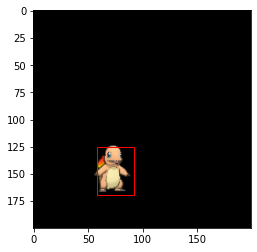

true location: 36 122 111 181
pred: 36 119 110 179
loss: 0.6021777454391122


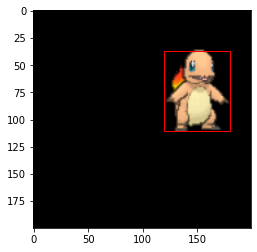

true location: 59 49 103 83
pred: 59 48 101 81
loss: 0.5365961542353034


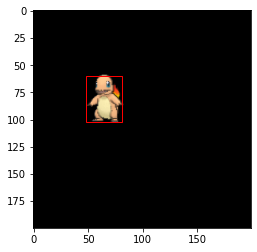

true location: 77 57 114 86
pred: 78 60 117 88
loss: 0.5395489225536585


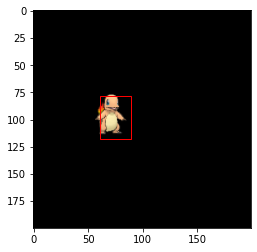

true location: 143 17 187 51
pred: 143 17 186 51
loss: 0.46784033483825627


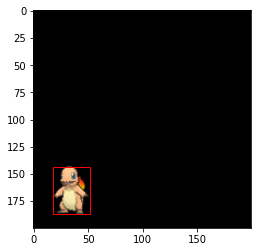

true location: 9 117 44 145
pred: 7 115 41 143
loss: 0.43288433092646306


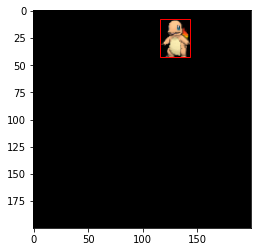

true location: 99 70 127 92
pred: 100 72 131 96
loss: 0.5235481866821646


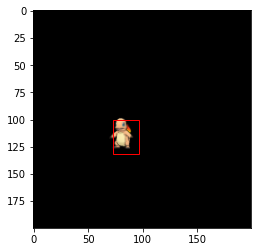

true location: 154 87 194 118
pred: 152 88 192 119
loss: 0.5389745962247252


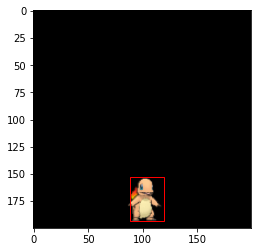

true location: 100 60 171 116
pred: 101 61 171 116
loss: 0.6369488256052136


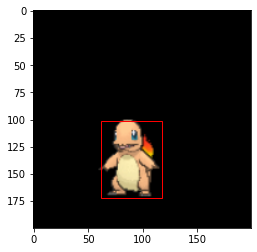

true location: 31 22 81 61
pred: 34 22 84 59
loss: 0.4587073086388409


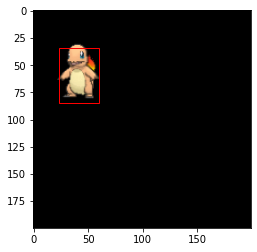

In [17]:
for _ in range(10):
    make_charmander_prediction_resize_flip(model_resize_flip)

# Localization 5
## task: put charmander on a background figure